In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from func import np, f1_score_cal, display_df, plot_image
import sys
sys.path.extend([str(Path.home() / "PycharmProjects/data_toolkit")])

from nlp.string_matching.function import run_match


def clean_text(text):
    return str(text).lower().strip()

cpu


In [2]:
path = Path.home() / 'OneDrive - Seagroup/computer_vison/shopee_item_images/'
path_img = path / 'train_images'

# input
df = pd.read_csv(path / 'train.csv')

# clean
df['filepath'] = df['image'].map(lambda x: str(path_img / x))
group_dicts = df.groupby('label_group')["posting_id"].apply(set).apply(list).to_dict()
df['target'] = df["label_group"].map(group_dicts)
df['title_edit'] = df['title'].map(clean_text)

df.head()

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_129225211, train_2278313361]",paper bag victoria secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_3423213080, train_3386243561]","double tape 3m vhb 12 mm x 4,5 m original / do..."
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_3803689425, train_2288590299]",maling tts canned pork luncheon meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_3342059966, train_2406599165]",daster batik lengan pendek - motif acak / camp...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_921438619, train_3369186413]",nescafe \xc3\x89clair latte 220ml


In [3]:
item = df['title_edit'].unique().tolist()
target_check = df['target'].tolist()

# find thresholds
thresholds = list(np.arange(0.4, 1, 0.1))
scores, plot_check, f1_score_lst, pred_lst = {}, {}, [], {}
for thres in thresholds:
    num = round(thres, 1)
    
    # run
    match_df = run_match(base=item, source=item, top=10, similarity=num)
    match_df['rank'] = match_df.groupby(['base'])['source'].transform(lambda x: pd.factorize(x)[0]).add(1)
    match_df = match_df.merge(df[['posting_id', 'title_edit']], how='left', left_on='base', right_on='title_edit')
    match_df = match_df.merge(df[['posting_id', 'title_edit']], how='left', left_on='source', right_on='title_edit', suffixes=('_base', '_source'))

    pred = match_df.groupby('posting_id_base')['posting_id_source'].apply(set).apply(list).to_dict()
    pred_check = df['posting_id'].map(pred).tolist()
    f1_score_lst = [f1_score_cal(i, v) for i, v in zip(target_check, pred_check)]
    
    score = np.mean(f1_score_lst)
    scores.update({num: score})
    plot_check.update({num: f1_score_lst})
    pred_lst.update({num: pred_check})
    print(f'--- F1 score for threshold {num} is {score:.3f} ---\n')
    
# choose thresholds 
best_score = max(scores, key=scores.get)
print(f'--- Best score is {round(scores[best_score], 4)} and has a threshold {best_score} ---')
df['text_pred'] = pred_lst[best_score]
df['f1_score'] = plot_check[best_score]

process vectorize: 1.86s
process optimized: 3.29s
32,629 skus in BASE match 32,629 skus in SOURCE
--- F1 score for threshold 0.4 is 0.579 ---

process vectorize: 1.9s
process optimized: 3.19s
32,629 skus in BASE match 32,629 skus in SOURCE
--- F1 score for threshold 0.5 is 0.636 ---

process vectorize: 2.29s
process optimized: 3.51s
32,629 skus in BASE match 32,629 skus in SOURCE
--- F1 score for threshold 0.6 is 0.637 ---

process vectorize: 2.66s
process optimized: 4.41s
32,629 skus in BASE match 32,629 skus in SOURCE
--- F1 score for threshold 0.7 is 0.601 ---

process vectorize: 2.19s
process optimized: 3.31s
32,629 skus in BASE match 32,629 skus in SOURCE
--- F1 score for threshold 0.8 is 0.554 ---

process vectorize: 2.3s
process optimized: 3.25s
32,629 skus in BASE match 32,629 skus in SOURCE
--- F1 score for threshold 0.9 is 0.510 ---

--- Best score is 0.6365 and has a threshold 0.6 ---


Text(0, 0.5, '')

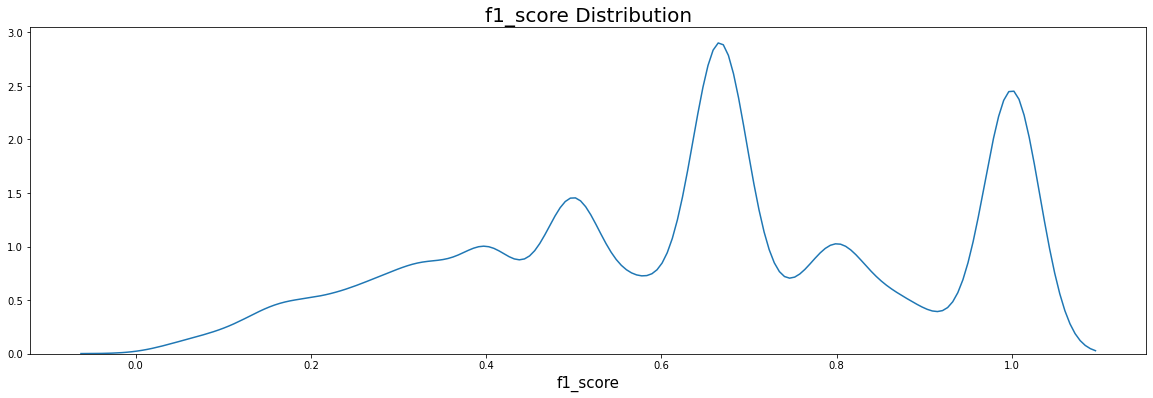

In [4]:
plt.figure(figsize=(20, 6))

plot = sns.kdeplot(x=df["f1_score"])
plt.title("f1_score Distribution", fontsize=20)
plt.xlabel("f1_score", fontsize=15)
plt.ylabel("")

In [5]:
df.head()

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit,text_pred,f1_score
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_129225211, train_2278313361]",paper bag victoria secret,"[train_129225211, train_2278313361]",1.000000
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_3423213080, train_3386243561]","double tape 3m vhb 12 mm x 4,5 m original / do...","[train_211200223, train_3386243561, train_8600...",0.571429
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_3803689425, train_2288590299]",maling tts canned pork luncheon meat 397 gr,"[train_3803689425, train_2288590299]",1.000000
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_3342059966, train_2406599165]",daster batik lengan pendek - motif acak / camp...,"[train_466135735, train_2043094887, train_1744...",0.200000
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_921438619, train_3369186413]",nescafe \xc3\x89clair latte 220ml,[train_3369186413],0.666667


In [12]:
df.iloc[34246]

posting_id                                       train_769054909
image                       fff401691371bdcb382a0d9075dfea6a.jpg
image_phash                                     be86851f72e2853c
title            MamyPoko Pants Royal Soft - S 70 - Popok Celana
label_group                                           2736479533
filepath       /Users/kevin/OneDrive - Seagroup/computer_viso...
target                       [train_769054909, train_1463059254]
title_edit       mamypoko pants royal soft - s 70 - popok celana
text_pred      [train_554463971, train_2530102819, train_3668...
f1_score                                                0.333333
Name: 34246, dtype: object

In [11]:
df.text_pred.str.len()

0         2
1         5
2         2
3         8
4         1
         ..
34245     1
34246    10
34247     4
34248     2
34249     1
Name: text_pred, Length: 34250, dtype: int64

In [13]:
df.query('posting_id == "train_769054909"')

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit,text_pred,f1_score
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_769054909, train_1463059254]",mamypoko pants royal soft - s 70 - popok celana,"[train_554463971, train_2530102819, train_3668...",0.333333


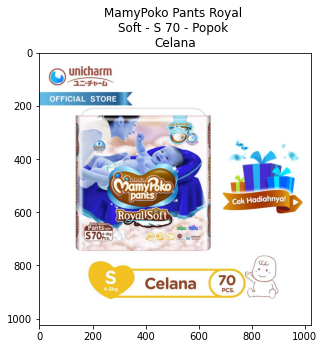

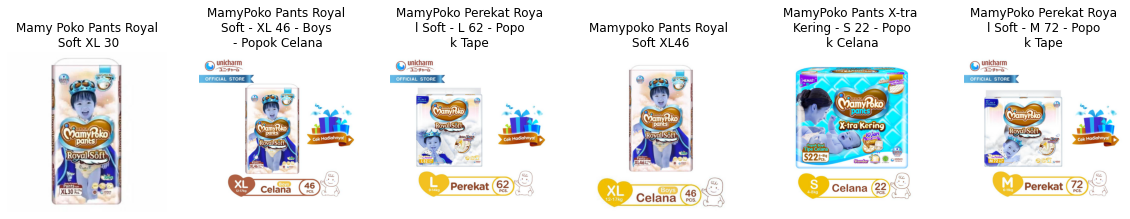

IndexError: list index out of range

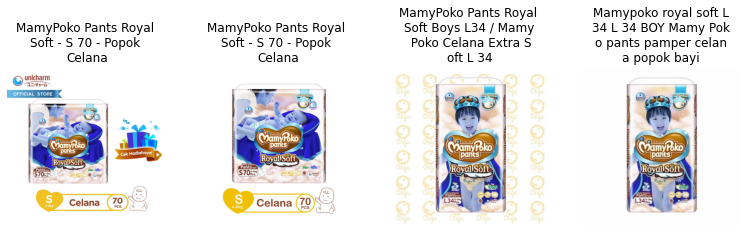

In [28]:
test_id = 'train_769054909'
tmp = pd.DataFrame(df.query(f'posting_id == "{test_id}"')['text_pred'].item(), columns=['posting_id'])
tmp = tmp.merge(df[['posting_id', 'filepath', 'title']], how='left')

plot_image(df.query(f'posting_id == "{test_id}"'))
display_df(tmp, path_img)

In [29]:
test_id = 'train_769054909'
tmp = pd.DataFrame(df.query(f'posting_id == "{test_id}"')['target'].item(), columns=['posting_id'])
tmp = tmp.merge(df[['posting_id', 'filepath', 'title']], how='left')
display_df(tmp, path_img)

In [30]:
tmp

,posting_id,filepath,title
0,train_769054909,/Users/kevin/OneDrive - Seagroup/computer_viso...,MamyPoko Pants Royal Soft - S 70 - Popok Celana
1,train_1463059254,/Users/kevin/OneDrive - Seagroup/computer_viso...,MamyPoko Pants Royal Soft - S 70 - Popok Celana


In [35]:
cols

1